In [1]:
# This file is a modified version of the original:
# https://www.kaggle.com/code/mipypf/ink-segmentation-2-5d-3dcnn-resnet3dcsn-fp16fold01/notebook?scriptVersionId=132226669

In [2]:
!pip uninstall -y timm
import sys
sys.path.append("/kaggle/input/timmmaster/")
import timm
print(timm.__version__)

Found existing installation: timm 0.6.12
Uninstalling timm-0.6.12:
  Successfully uninstalled timm-0.6.12
0.9.5


In [3]:
!pip install /kaggle/input/mmdetection-offline-lib/mmcv_full-1.3.14-cp37-cp37m-linux_x86_64.whl --no-deps
!pip install /kaggle/input/mmdetection-offline-lib/pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl --no-deps
!pip install /kaggle/input/mmdetection-offline-lib/terminaltables-3.1.0-py3-none-any.whl --no-deps
!pip install /kaggle/input/mmdetection-offline-lib/pytest_runner-5.3.1-py3-none-any.whl --no-deps
!pip install /kaggle/input/mmdetection-offline-lib/mmpycocotools-12.0.3-cp37-cp37m-linux_x86_64.whl --no-deps
!pip install /kaggle/input/mmdetection-offline-lib/terminal-0.4.0-py3-none-any.whl --no-deps
!pip install /kaggle/input/mmdetection-offline-lib/mmdet-2.17.0-py3-none-any.whl --no-deps
!pip install /kaggle/input/mmdetection-offline-lib/addict-2.4.0-py3-none-any.whl --no-deps
!pip install /kaggle/input/mmdetection-offline-lib/yapf-0.31.0-py2.py3-none-any.whl --no-deps

Processing /kaggle/input/mmdetection-offline-lib/mmcv_full-1.3.14-cp37-cp37m-linux_x86_64.whl
Processing /kaggle/input/mmdetection-offline-lib/pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl
Processing /kaggle/input/mmdetection-offline-lib/terminaltables-3.1.0-py3-none-any.whl
Processing /kaggle/input/mmdetection-offline-lib/pytest_runner-5.3.1-py3-none-any.whl
Processing /kaggle/input/mmdetection-offline-lib/mmpycocotools-12.0.3-cp37-cp37m-linux_x86_64.whl
Processing /kaggle/input/mmdetection-offline-lib/terminal-0.4.0-py3-none-any.whl
Processing /kaggle/input/mmdetection-offline-lib/mmdet-2.17.0-py3-none-any.whl
Processing /kaggle/input/mmdetection-offline-lib/addict-2.4.0-py3-none-any.whl
Processing /kaggle/input/mmdetection-offline-lib/yapf-0.31.0-py2.py3-none-any.whl
  Attempting uninstall: yapf
    Found existing installation: yapf 0.32.0
    Uninstalling yapf-0.32.0:
      Successfully uninstalled yapf-0.32.0


In [4]:
import argparse
import datetime
import math
import os
import warnings
from functools import lru_cache, partial
from glob import glob
from typing import Callable, List, Tuple

import albumentations as albu
import numpy as np
import PIL.Image as Image
import pytorch_lightning as pl
import torch
from albumentations.pytorch import ToTensorV2
from pytorch_lightning import LightningDataModule, callbacks
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.utilities import rank_zero_info
from torch import nn
from torch.nn import functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from transformers import get_cosine_schedule_with_warmup
from timm.utils import ModelEmaV2

from io import StringIO

import gc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATCH_SIZE = 32


### Volume to patch(32x32 size npy)

In [5]:
import os
import warnings

import numpy as np
import PIL.Image as Image
from tqdm.auto import tqdm, trange

warnings.simplefilter("ignore")

PREFIX = "/kaggle/input/vesuvius-challenge-ink-detection/test"

test_fragments = sorted(glob(f"{PREFIX}/*"))
fragment_ids = [idx.split("/")[-1] for idx in test_fragments]
for data_id in tqdm(fragment_ids):
    mask = np.array(Image.open(PREFIX + f"/{data_id}/mask.png").convert("1"))
    volume = np.stack(
        [
            (np.array(Image.open(filename), dtype=np.float32) / 65535.0).astype(np.float16)
            for filename in sorted(
                glob(PREFIX + f"/{data_id}/surface_volume/*.tif")
            )
        ]
    )
    volume_dir = f"vesuvius_patches_{PATCH_SIZE}/test/{data_id}/surface_volume/"
    mask_dir = f"vesuvius_patches_{PATCH_SIZE}/test/{data_id}/mask/"
    os.makedirs(volume_dir, exist_ok=True)
    os.makedirs(mask_dir, exist_ok=True)

    h, w = volume.shape[-2:]
    for i in trange(h // PATCH_SIZE, leave=False):
        for j in range(w // PATCH_SIZE):
            start_h = i * PATCH_SIZE
            start_w = j * PATCH_SIZE
            mask_patch = mask[
                ..., start_h : start_h + PATCH_SIZE, start_w : start_w + PATCH_SIZE
            ]
            if not mask_patch.sum():
                continue
            volume_patch = volume[
                ..., start_h : start_h + PATCH_SIZE, start_w : start_w + PATCH_SIZE
            ].astype(np.float32)
            np.save(os.path.join(volume_dir, f"volume_{i}_{j}"), volume_patch)
            np.save(os.path.join(mask_dir, f"mask_{i}_{j}"), mask_patch)
    del volume, mask
    gc.collect()


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

### Define dataloader, preprocess

In [6]:
def get_transforms(train: bool = False) -> Callable:
    if train:
        return albu.Compose(
            [
                albu.Flip(p=0.5),
                albu.RandomRotate90(p=0.9),
                albu.ShiftScaleRotate(
                    shift_limit=0.0625,
                    scale_limit=0.2,
                    rotate_limit=15,
                    p=0.9,
                ),
                albu.OneOf(
                    [
                        albu.ElasticTransform(p=0.3),
                        albu.GaussianBlur(p=0.3),
                        albu.GaussNoise(p=0.3),
                        albu.OpticalDistortion(p=0.3),
                        albu.GridDistortion(p=0.1),
                        albu.PiecewiseAffine(p=0.3),  # IAAPiecewiseAffine
                    ],
                    p=0.9,
                ),
                albu.RandomBrightnessContrast(
                    brightness_limit=0.3, contrast_limit=0.3, p=0.3
                ),
                ToTensorV2(),
            ]
        )

    else:
        return albu.Compose(
            [
                ToTensorV2(),
            ]
        )


class PatchDataset(Dataset):
    def __init__(
        self,
        volume_paths: List[str],
        image_size: Tuple[int, int] = (256, 256),
        mode: str = "train",  # "train" | "valid" | "test"
        preprocess_in_model: bool = False,
        start_z: int = 8,
        end_z: int = -8,
        shift_z: int = 2,
    ):
        self.volume_paths = volume_paths
        self.image_size = image_size
        assert (image_size[0] % 32 == 0) and (image_size[1] % 32 == 0)
        self.mode = mode
        self.train = mode == "train"
        self.transforms = get_transforms(self.train)
        self.PATCH_SIZE = 32
        self.preprocess_in_model = preprocess_in_model
        self.start_z = start_z
        self.end_z = end_z
        self.shift_z = shift_z

    def __len__(self) -> int:
        if self.mode == "train":
            return 25000
        elif self.mode == "valid":
            return 24000
        else:
            return len(self.volume_paths)

#     @lru_cache(maxsize=64)
    def np_load(self, path: str) -> np.ndarray:
        return np.load(path)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, int, int]:
        if self.train:
            np_load = np.load
            idx = np.random.choice(np.arange(len(self.volume_paths)))
        else:
            np_load = self.np_load
        volume = np.zeros((65, *self.image_size), dtype=np.float32)
        label = np.zeros(self.image_size)
        volume_lt_path = self.volume_paths[idx]
        data_prefix = "/".join(volume_lt_path.split("/")[:-3])
        data_source = volume_lt_path.split("/")[-3]
        y, x = volume_lt_path.split("/")[-1].split(".")[-2].split("_")[-2:]
        x = int(x)
        y = int(y)
        for i in range(self.image_size[0] // self.PATCH_SIZE):
            for j in range(self.image_size[1] // self.PATCH_SIZE):
                volume_path = os.path.join(
                    data_prefix,
                    data_source,
                    f"surface_volume/volume_{y + i}_{x + j}.npy",
                )
                label_path = os.path.join(
                    data_prefix, data_source, f"label/label_{y + i}_{x + j}.npy"
                )
                if os.path.exists(volume_path):
                    volume[
                        :,
                        i * self.PATCH_SIZE : (i + 1) * self.PATCH_SIZE,
                        j * self.PATCH_SIZE : (j + 1) * self.PATCH_SIZE,
                    ] = np_load(volume_path)
                    if os.path.exists(label_path):
                        label[
                            i * self.PATCH_SIZE : (i + 1) * self.PATCH_SIZE,
                            j * self.PATCH_SIZE : (j + 1) * self.PATCH_SIZE,
                        ] = np_load(label_path)
        if not self.preprocess_in_model:
            if self.train and np.random.rand() < 0.5:
                shift = np.random.randint(-self.shift_z, self.shift_z + 1)
            else:
                shift = 0
            # TODO: Add test for shift range
            volume = volume[
                self.start_z + shift : self.end_z + shift
            ]  # use middle 49 layer
        volume = volume.transpose(1, 2, 0)
        aug = self.transforms(image=volume, mask=label)
        volume = aug["image"]
        label = aug["mask"][None, :]
        if self.train:
            volume, label = grid_cutout(
                volume=volume, label=label, max_height=2, max_width=2, prob=0.5
            )
        return (
            volume.half(),
            label.half(),
            x,
            y,
        )


class InkDetDataModule(LightningDataModule):
    def __init__(
        self,
        train_volume_paths: List[str],
        valid_volume_paths: List[str],
        image_size: int = 256,
        num_workers: int = 4,
        batch_size: int = 16,
        preprocess_in_model: bool = False,
        start_z: int = 8,
        end_z: int = -8,
        shift_z: int = 2,
    ):
        super().__init__()

        self._num_workers = num_workers
        self._batch_size = batch_size
        self.train_volume_paths = train_volume_paths
        self.valid_volume_paths = valid_volume_paths
        self.image_size = (image_size, image_size)
        self.preprocess_in_model = preprocess_in_model
        self.start_z = start_z
        self.end_z = end_z
        self.shift_z = shift_z
        self.save_hyperparameters(
            "num_workers",
            "batch_size",
            "image_size",
            "preprocess_in_model",
            "start_z",
            "end_z",
            "shift_z",
        )

    def create_dataset(self, mode: str = "train") -> PatchDataset:
        if mode == "train":
            return PatchDataset(
                volume_paths=self.train_volume_paths,
                image_size=self.image_size,
                mode=mode,
                preprocess_in_model=self.preprocess_in_model,
                start_z=self.start_z,
                end_z=self.end_z,
                shift_z=self.shift_z,
            )
        else:
            return PatchDataset(
                volume_paths=self.valid_volume_paths,
                image_size=self.image_size,
                mode=mode,
                preprocess_in_model=self.preprocess_in_model,
                start_z=self.start_z,
                end_z=self.end_z,
                shift_z=self.shift_z,
            )

    def __dataloader(self, mode: str = "train") -> DataLoader:
        """Train/validation loaders."""
        dataset = self.create_dataset(mode)
        return DataLoader(
            dataset=dataset,
            batch_size=self._batch_size,
            num_workers=self._num_workers,
            shuffle=(mode == "train"),
            drop_last=(mode == "train"),
            # worker_init_fn=lambda x: np.random.seed(np.random.get_state()[1][0] + x),
            pin_memory=True,
        )

    def train_dataloader(self) -> DataLoader:
        return self.__dataloader(mode="train")

    def val_dataloader(self) -> DataLoader:
        return self.__dataloader(mode="valid")

    def test_dataloader(self) -> DataLoader:
        return self.__dataloader(mode="test")

### Define 2.5D_3DCNN Model (timm backbone)

In [7]:
def downsample_conv(
    in_channels: int,
    out_channels: int,
    stride: int = 2,
):
    return nn.Sequential(
        *[
            nn.Conv3d(
                in_channels,
                out_channels,
                1,
                stride=(1, stride, stride),
                padding=0,
                bias=False,
            ),
            nn.BatchNorm3d(out_channels),
        ]
    )


class ResidualConv3D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        mid_channels: int,
        out_channels: int,
        stride: int = 2,
    ):
        super().__init__()

        self.conv1 = nn.Conv3d(in_channels, mid_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm3d(mid_channels)
        self.act1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Sequential(
            nn.Conv3d(mid_channels, mid_channels, kernel_size=1, stride=1, bias=False),
            nn.Conv3d(
                mid_channels,
                mid_channels,
                kernel_size=3,
                stride=(1, stride, stride),
                padding=1,
                bias=False,
                groups=mid_channels,
            ),
        )
        self.bn2 = nn.BatchNorm3d(mid_channels)
        self.act2 = nn.ReLU(inplace=True)

        self.conv3 = nn.Conv3d(mid_channels, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm3d(out_channels)

        self.act3 = nn.ReLU(inplace=True)
        self.downsample = downsample_conv(
            in_channels,
            out_channels,
            stride=stride,
        )
        self.stride = stride
        self.zero_init_last()

    def zero_init_last(self):
        if getattr(self.bn3, "weight", None) is not None:
            nn.init.zeros_(self.bn3.weight)

    def forward(self, x: torch.Tensor):
        shortcut = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)

        x = self.conv3(x)
        x = self.bn3(x)

        if self.downsample is not None:
            shortcut = self.downsample(shortcut)
        x += shortcut
        x = self.act3(x)

        return x


class InkDetModel(nn.Module):
    def __init__(
        self,
        model_name: str = "resnet34",
        pretrained: bool = False,
        drop_rate: float = 0,
        drop_path_rate: float = 0,
        num_3d_layer: int = 3,
        in_chans: int = 7,
        preprocess_in_model: bool = False,
        start_z: int = 8,
        end_z: int = -8,
        shift_z: int = 2,
        num_class: int = 1,
    ):
        super().__init__()
        self.encoder = timm.create_model(
            model_name,
            pretrained=pretrained,
            in_chans=in_chans,
            features_only=True,
            drop_rate=drop_rate,
            drop_path_rate=drop_path_rate,
        )
        self.output_fmt = getattr(self.encoder, "output_fmt", "NHCW")
        self.in_chans = in_chans
        num_features = self.encoder.feature_info.channels()[-1]
        self.conv_proj = nn.Sequential(
            nn.Conv2d(num_features, 512, 1, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.conv3d = nn.Sequential(
            *[
                ResidualConv3D(
                    512,
                    512,
                    512,
                    1,
                )
                for _ in range(num_3d_layer)
            ]
        )
        self.head = nn.Sequential(
            nn.Conv2d(
                512 * 2,
                512,
                1,
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.Conv2d(
                512,
                num_class,
                1,
            ),
        )
        self.preprocess_in_model = preprocess_in_model
        self.start_z = start_z
        self.end_z = end_z
        self.shift_z = shift_z

    def preprocess(self, img):
        if self.training and np.random.rand() < 0.5:
            shift = np.random.randint(-self.shift_z, self.shift_z + 1)
        else:
            shift = 0
        img = img[:, self.start_z + shift : self.end_z + shift]
        return img

    def forward_image_feats(self, img):
        if self.preprocess_in_model:
            img = self.preprocess(img)
        mean = img.mean(dim=(1, 2, 3), keepdim=True)
        std = img.std(dim=(1, 2, 3), keepdim=True) + 1e-6
        img = (img - mean) / std
        bs, ch, h, w = img.shape
        assert ch % self.in_chans == 0
        groups_3d = ch // self.in_chans
        img = img.reshape((bs, groups_3d, self.in_chans, h, w))

        if self.training:
            ch_arr = list(range(img.shape[2]))
            ch_arr = [
                random.sample(ch_arr, len(ch_arr)) if np.random.rand() < 0.2 else ch_arr
                for _ in range(img.shape[0])
            ]
            for i, ca in enumerate(ch_arr):
                img[i] = img[i, :, ca]
        img = img.reshape(bs * groups_3d, self.in_chans, h, w)
        img_feat = self.encoder(img)[-1]
        if self.output_fmt == "NHWC":
            img_feat = img_feat.permute(0, 3, 1, 2).contiguous()
        img_feat = self.conv_proj(img_feat)  # (bs * groups_3d, 512, h, w)
        _, ch, h, w = img_feat.shape
        img_feat = img_feat.reshape(bs, groups_3d, ch, h, w).transpose(
            1, 2
        )  # (bs, ch, groups_3d, h, w)
        img_feat = self.conv3d(img_feat)  # (bs, ch, groups_3d, h, w)
        img_feat = torch.cat([img_feat.mean(2), img_feat.max(2)[0]], 1)
        return img_feat

    def forward(
        self,
        img: torch.Tensor,
    ):
        """
        img: (bs, ch, h, w)
        """
        img_feat = self.forward_image_feats(img)
        return self.head(img_feat)


class InkDetLightningModel(pl.LightningModule):
    def __init__(
        self,
        valid_fragment_id: str,
        model_name: str = "resnet34",
        pretrained: bool = False,
        drop_rate: float = 0,
        drop_path_rate: float = 0,
        num_3d_layer: int = 3,
        in_chans: int = 7,
        preprocess_in_model: bool = False,
        start_z: int = 8,
        end_z: int = -8,
        shift_z: int = 2,
        mixup_p: float = 0.0,
        mixup_alpha: float = 0.5,
        no_mixup_epochs: int = 0,
        lr: float = 1e-3,
        backbone_lr: float = None,
    ) -> None:
        super().__init__()
        self.__build_model(
            model_name=model_name,
            pretrained=pretrained,
            drop_rate=drop_rate,
            drop_path_rate=drop_path_rate,
            num_3d_layer=num_3d_layer,
            preprocess_in_model=preprocess_in_model,
            start_z=start_z,
            end_z=end_z,
            shift_z=shift_z,
            in_chans=in_chans,
        )
        self.save_hyperparameters()

    def __build_model(
        self,
        model_name: str = "resnet34",
        pretrained: bool = False,
        drop_rate: float = 0,
        drop_path_rate: float = 0,
        num_3d_layer: int = 3,
        in_chans: int = 7,
        preprocess_in_model: bool = False,
        start_z: int = 8,
        end_z: int = -8,
        shift_z: int = 2,
    ):
        self.model = InkDetModel(
            model_name=model_name,
            pretrained=pretrained,
            drop_rate=drop_rate,
            drop_path_rate=drop_path_rate,
            num_3d_layer=num_3d_layer,
            in_chans=in_chans,
            preprocess_in_model=preprocess_in_model,
            start_z=start_z,
            end_z=end_z,
            shift_z=shift_z,
            num_class=1,
        )
        self.model_ema = ModelEmaV2(self.model, decay=0.99)
        
    def predict(self, volume):
        output = torch.sigmoid(self.model_ema.module(volume))
        output = F.interpolate(
            output.float(),
            scale_factor=32,
            mode="bilinear",
            align_corners=True,
        ).half()
        return output

## Define ResNet3DCSN

In [8]:
# Copyright (c) OpenMMLab. All rights reserved.

import logging
import warnings

import torch.utils.checkpoint as cp
from mmcv.cnn import (
    ConvModule,
    NonLocal3d,
    build_activation_layer,
    constant_init,
    kaiming_init,
)
from mmcv.runner import _load_checkpoint, load_checkpoint
from timm.layers import DropPath
from torch import nn
from torch.nn.modules.batchnorm import _BatchNorm
from torch.nn.modules.utils import _ntuple, _triple


class BasicBlock3d(nn.Module):
    """BasicBlock 3d block for ResNet3D.
    Args:
        inplanes (int): Number of channels for the input in first conv3d layer.
        planes (int): Number of channels produced by some norm/conv3d layers.
        spatial_stride (int): Spatial stride in the conv3d layer. Default: 1.
        temporal_stride (int): Temporal stride in the conv3d layer. Default: 1.
        dilation (int): Spacing between kernel elements. Default: 1.
        downsample (nn.Module | None): Downsample layer. Default: None.
        style (str): ``pytorch`` or ``caffe``. If set to "pytorch", the
            stride-two layer is the 3x3 conv layer, otherwise the stride-two
            layer is the first 1x1 conv layer. Default: 'pytorch'.
        inflate (bool): Whether to inflate kernel. Default: True.
        non_local (bool): Determine whether to apply non-local module in this
            block. Default: False.
        non_local_cfg (dict): Config for non-local module. Default: ``dict()``.
        conv_cfg (dict): Config dict for convolution layer.
            Default: ``dict(type='Conv3d')``.
        norm_cfg (dict): Config for norm layers. required keys are ``type``,
            Default: ``dict(type='BN3d')``.
        act_cfg (dict): Config dict for activation layer.
            Default: ``dict(type='ReLU')``.
        with_cp (bool): Use checkpoint or not. Using checkpoint will save some
            memory while slowing down the training speed. Default: False.
    """

    expansion = 1

    def __init__(
        self,
        inplanes,
        planes,
        spatial_stride=1,
        temporal_stride=1,
        dilation=1,
        downsample=None,
        style="pytorch",
        inflate=True,
        non_local=False,
        non_local_cfg=dict(),
        conv_cfg=dict(type="Conv3d"),
        norm_cfg=dict(type="BN3d"),
        act_cfg=dict(type="ReLU"),
        with_cp=False,
        drop_path=None,
        **kwargs,
    ):
        super().__init__()
        assert style in ["pytorch", "caffe"]
        # make sure that only ``inflate_style`` is passed into kwargs
        assert set(kwargs).issubset(["inflate_style"])

        self.inplanes = inplanes
        self.planes = planes
        self.spatial_stride = spatial_stride
        self.temporal_stride = temporal_stride
        self.dilation = dilation
        self.style = style
        self.inflate = inflate
        self.conv_cfg = conv_cfg
        self.norm_cfg = norm_cfg
        self.act_cfg = act_cfg
        self.with_cp = with_cp
        self.non_local = non_local
        self.non_local_cfg = non_local_cfg

        self.conv1_stride_s = spatial_stride
        self.conv2_stride_s = 1
        self.conv1_stride_t = temporal_stride
        self.conv2_stride_t = 1

        if self.inflate:
            conv1_kernel_size = (3, 3, 3)
            conv1_padding = (1, dilation, dilation)
            conv2_kernel_size = (3, 3, 3)
            conv2_padding = (1, 1, 1)
        else:
            conv1_kernel_size = (1, 3, 3)
            conv1_padding = (0, dilation, dilation)
            conv2_kernel_size = (1, 3, 3)
            conv2_padding = (0, 1, 1)

        self.conv1 = ConvModule(
            inplanes,
            planes,
            conv1_kernel_size,
            stride=(self.conv1_stride_t, self.conv1_stride_s, self.conv1_stride_s),
            padding=conv1_padding,
            dilation=(1, dilation, dilation),
            bias=False,
            conv_cfg=self.conv_cfg,
            norm_cfg=self.norm_cfg,
            act_cfg=self.act_cfg,
        )

        self.conv2 = ConvModule(
            planes,
            planes * self.expansion,
            conv2_kernel_size,
            stride=(self.conv2_stride_t, self.conv2_stride_s, self.conv2_stride_s),
            padding=conv2_padding,
            bias=False,
            conv_cfg=self.conv_cfg,
            norm_cfg=self.norm_cfg,
            act_cfg=None,
        )

        self.downsample = downsample
        self.relu = build_activation_layer(self.act_cfg)

        if self.non_local:
            self.non_local_block = NonLocal3d(
                self.conv2.norm.num_features, **self.non_local_cfg
            )
        self.drop_path = drop_path

    def forward(self, x):
        """Defines the computation performed at every call."""

        def _inner_forward(x):
            """Forward wrapper for utilizing checkpoint."""
            identity = x

            out = self.conv1(x)
            out = self.conv2(out)
            if self.drop_path is not None:
                x = self.drop_path(x)
            if self.downsample is not None:
                identity = self.downsample(x)

            out = out + identity
            return out

        if self.with_cp and x.requires_grad:
            out = cp.checkpoint(_inner_forward, x)
        else:
            out = _inner_forward(x)
        out = self.relu(out)

        if self.non_local:
            out = self.non_local_block(out)

        return out


class Bottleneck3d(nn.Module):
    """Bottleneck 3d block for ResNet3D.
    Args:
        inplanes (int): Number of channels for the input in first conv3d layer.
        planes (int): Number of channels produced by some norm/conv3d layers.
        spatial_stride (int): Spatial stride in the conv3d layer. Default: 1.
        temporal_stride (int): Temporal stride in the conv3d layer. Default: 1.
        dilation (int): Spacing between kernel elements. Default: 1.
        downsample (nn.Module | None): Downsample layer. Default: None.
        style (str): ``pytorch`` or ``caffe``. If set to "pytorch", the
            stride-two layer is the 3x3 conv layer, otherwise the stride-two
            layer is the first 1x1 conv layer. Default: 'pytorch'.
        inflate (bool): Whether to inflate kernel. Default: True.
        inflate_style (str): ``3x1x1`` or ``3x3x3``. which determines the
            kernel sizes and padding strides for conv1 and conv2 in each block.
            Default: '3x1x1'.
        non_local (bool): Determine whether to apply non-local module in this
            block. Default: False.
        non_local_cfg (dict): Config for non-local module. Default: ``dict()``.
        conv_cfg (dict): Config dict for convolution layer.
            Default: ``dict(type='Conv3d')``.
        norm_cfg (dict): Config for norm layers. required keys are ``type``,
            Default: ``dict(type='BN3d')``.
        act_cfg (dict): Config dict for activation layer.
            Default: ``dict(type='ReLU')``.
        with_cp (bool): Use checkpoint or not. Using checkpoint will save some
            memory while slowing down the training speed. Default: False.
    """

    expansion = 4

    def __init__(
        self,
        inplanes,
        planes,
        spatial_stride=1,
        temporal_stride=1,
        dilation=1,
        downsample=None,
        style="pytorch",
        inflate=True,
        inflate_style="3x1x1",
        non_local=False,
        non_local_cfg=dict(),
        conv_cfg=dict(type="Conv3d"),
        norm_cfg=dict(type="BN3d"),
        act_cfg=dict(type="ReLU"),
        with_cp=False,
        drop_path=None,
    ):
        super().__init__()
        assert style in ["pytorch", "caffe"]
        assert inflate_style in ["3x1x1", "3x3x3"]

        self.inplanes = inplanes
        self.planes = planes
        self.spatial_stride = spatial_stride
        self.temporal_stride = temporal_stride
        self.dilation = dilation
        self.style = style
        self.inflate = inflate
        self.inflate_style = inflate_style
        self.norm_cfg = norm_cfg
        self.conv_cfg = conv_cfg
        self.act_cfg = act_cfg
        self.with_cp = with_cp
        self.non_local = non_local
        self.non_local_cfg = non_local_cfg

        if self.style == "pytorch":
            self.conv1_stride_s = 1
            self.conv2_stride_s = spatial_stride
            self.conv1_stride_t = 1
            self.conv2_stride_t = temporal_stride
        else:
            self.conv1_stride_s = spatial_stride
            self.conv2_stride_s = 1
            self.conv1_stride_t = temporal_stride
            self.conv2_stride_t = 1

        if self.inflate:
            if inflate_style == "3x1x1":
                conv1_kernel_size = (3, 1, 1)
                conv1_padding = (1, 0, 0)
                conv2_kernel_size = (1, 3, 3)
                conv2_padding = (0, dilation, dilation)
            else:
                conv1_kernel_size = (1, 1, 1)
                conv1_padding = (0, 0, 0)
                conv2_kernel_size = (3, 3, 3)
                conv2_padding = (1, dilation, dilation)
        else:
            conv1_kernel_size = (1, 1, 1)
            conv1_padding = (0, 0, 0)
            conv2_kernel_size = (1, 3, 3)
            conv2_padding = (0, dilation, dilation)

        self.conv1 = ConvModule(
            inplanes,
            planes,
            conv1_kernel_size,
            stride=(self.conv1_stride_t, self.conv1_stride_s, self.conv1_stride_s),
            padding=conv1_padding,
            bias=False,
            conv_cfg=self.conv_cfg,
            norm_cfg=self.norm_cfg,
            act_cfg=self.act_cfg,
        )

        self.conv2 = ConvModule(
            planes,
            planes,
            conv2_kernel_size,
            stride=(self.conv2_stride_t, self.conv2_stride_s, self.conv2_stride_s),
            padding=conv2_padding,
            dilation=(1, dilation, dilation),
            bias=False,
            conv_cfg=self.conv_cfg,
            norm_cfg=self.norm_cfg,
            act_cfg=self.act_cfg,
        )

        self.conv3 = ConvModule(
            planes,
            planes * self.expansion,
            1,
            bias=False,
            conv_cfg=self.conv_cfg,
            norm_cfg=self.norm_cfg,
            # No activation in the third ConvModule for bottleneck
            act_cfg=None,
        )

        self.downsample = downsample
        self.relu = build_activation_layer(self.act_cfg)

        if self.non_local:
            self.non_local_block = NonLocal3d(
                self.conv3.norm.num_features, **self.non_local_cfg
            )
        self.drop_path = drop_path

    def forward(self, x):
        """Defines the computation performed at every call."""

        def _inner_forward(x):
            """Forward wrapper for utilizing checkpoint."""
            identity = x

            out = self.conv1(x)
            out = self.conv2(out)
            out = self.conv3(out)

            if self.drop_path is not None:
                x = self.drop_path(x)

            if self.downsample is not None:
                identity = self.downsample(x)

            out = out + identity
            return out

        if self.with_cp and x.requires_grad:
            out = cp.checkpoint(_inner_forward, x)
        else:
            out = _inner_forward(x)
        out = self.relu(out)

        if self.non_local:
            out = self.non_local_block(out)

        return out


class ResNet3d(nn.Module):
    """ResNet 3d backbone.
    Args:
        depth (int): Depth of resnet, from {18, 34, 50, 101, 152}.
        pretrained (str | None): Name of pretrained model.
        stage_blocks (tuple | None): Set number of stages for each res layer.
            Default: None.
        pretrained2d (bool): Whether to load pretrained 2D model.
            Default: True.
        in_channels (int): Channel num of input features. Default: 3.
        base_channels (int): Channel num of stem output features. Default: 64.
        out_indices (Sequence[int]): Indices of output feature. Default: (3, ).
        num_stages (int): Resnet stages. Default: 4.
        spatial_strides (Sequence[int]):
            Spatial strides of residual blocks of each stage.
            Default: ``(1, 2, 2, 2)``.
        temporal_strides (Sequence[int]):
            Temporal strides of residual blocks of each stage.
            Default: ``(1, 1, 1, 1)``.
        dilations (Sequence[int]): Dilation of each stage.
            Default: ``(1, 1, 1, 1)``.
        conv1_kernel (Sequence[int]): Kernel size of the first conv layer.
            Default: ``(3, 7, 7)``.
        conv1_stride_s (int): Spatial stride of the first conv layer.
            Default: 2.
        conv1_stride_t (int): Temporal stride of the first conv layer.
            Default: 1.
        pool1_stride_s (int): Spatial stride of the first pooling layer.
            Default: 2.
        pool1_stride_t (int): Temporal stride of the first pooling layer.
            Default: 1.
        with_pool2 (bool): Whether to use pool2. Default: True.
        style (str): `pytorch` or `caffe`. If set to "pytorch", the stride-two
            layer is the 3x3 conv layer, otherwise the stride-two layer is
            the first 1x1 conv layer. Default: 'pytorch'.
        frozen_stages (int): Stages to be frozen (all param fixed). -1 means
            not freezing any parameters. Default: -1.
        inflate (Sequence[int]): Inflate Dims of each block.
            Default: (1, 1, 1, 1).
        inflate_style (str): ``3x1x1`` or ``3x3x3``. which determines the
            kernel sizes and padding strides for conv1 and conv2 in each block.
            Default: '3x1x1'.
        conv_cfg (dict): Config for conv layers. required keys are ``type``
            Default: ``dict(type='Conv3d')``.
        norm_cfg (dict): Config for norm layers. required keys are ``type`` and
            ``requires_grad``.
            Default: ``dict(type='BN3d', requires_grad=True)``.
        act_cfg (dict): Config dict for activation layer.
            Default: ``dict(type='ReLU', inplace=True)``.
        norm_eval (bool): Whether to set BN layers to eval mode, namely, freeze
            running stats (mean and var). Default: False.
        with_cp (bool): Use checkpoint or not. Using checkpoint will save some
            memory while slowing down the training speed. Default: False.
        non_local (Sequence[int]): Determine whether to apply non-local module
            in the corresponding block of each stages. Default: (0, 0, 0, 0).
        non_local_cfg (dict): Config for non-local module. Default: ``dict()``.
        zero_init_residual (bool):
            Whether to use zero initialization for residual block,
            Default: True.
        kwargs (dict, optional): Key arguments for "make_res_layer".
    """

    arch_settings = {
        18: (BasicBlock3d, (2, 2, 2, 2)),
        34: (BasicBlock3d, (3, 4, 6, 3)),
        50: (Bottleneck3d, (3, 4, 6, 3)),
        101: (Bottleneck3d, (3, 4, 23, 3)),
        152: (Bottleneck3d, (3, 8, 36, 3)),
    }

    def __init__(
        self,
        depth,
        pretrained,
        stage_blocks=None,
        pretrained2d=True,
        in_channels=3,
        num_stages=4,
        base_channels=64,
        out_indices=(
            0,
            1,
            2,
            3,
        ),
        spatial_strides=(1, 2, 2, 2),
        temporal_strides=(1, 1, 1, 1),
        dilations=(1, 1, 1, 1),
        conv1_kernel=(3, 7, 7),
        conv1_stride_s=2,
        conv1_stride_t=1,
        pool1_stride_s=2,
        pool1_stride_t=1,
        with_pool1=True,
        with_pool2=True,
        style="pytorch",
        frozen_stages=-1,
        inflate=(1, 1, 1, 1),
        inflate_style="3x1x1",
        conv_cfg=dict(type="Conv3d"),
        norm_cfg=dict(type="BN3d", requires_grad=True),
        act_cfg=dict(type="ReLU", inplace=True),
        norm_eval=False,
        with_cp=False,
        non_local=(0, 0, 0, 0),
        non_local_cfg=dict(),
        zero_init_residual=True,
        drop_path_rate=0.0,
        **kwargs,
    ):
        super().__init__()
        if depth not in self.arch_settings:
            raise KeyError(f"invalid depth {depth} for resnet")
        self.depth = depth
        self.pretrained = pretrained
        self.pretrained2d = pretrained2d
        self.in_channels = in_channels
        self.base_channels = base_channels
        self.num_stages = num_stages
        assert 1 <= num_stages <= 4
        self.stage_blocks = stage_blocks
        self.out_indices = out_indices
        assert max(out_indices) < num_stages
        self.spatial_strides = spatial_strides
        self.temporal_strides = temporal_strides
        self.dilations = dilations
        assert (
            len(spatial_strides)
            == len(temporal_strides)
            == len(dilations)
            == num_stages
        )
        if self.stage_blocks is not None:
            assert len(self.stage_blocks) == num_stages

        self.conv1_kernel = conv1_kernel
        self.conv1_stride_s = conv1_stride_s
        self.conv1_stride_t = conv1_stride_t
        self.pool1_stride_s = pool1_stride_s
        self.pool1_stride_t = pool1_stride_t
        self.with_pool1 = with_pool1
        self.with_pool2 = with_pool2
        self.style = style
        self.frozen_stages = frozen_stages
        self.stage_inflations = _ntuple(num_stages)(inflate)
        self.non_local_stages = _ntuple(num_stages)(non_local)
        self.inflate_style = inflate_style
        self.conv_cfg = conv_cfg
        self.norm_cfg = norm_cfg
        self.act_cfg = act_cfg
        self.norm_eval = norm_eval
        self.with_cp = with_cp
        self.zero_init_residual = zero_init_residual

        self.block, stage_blocks = self.arch_settings[depth]

        if self.stage_blocks is None:
            self.stage_blocks = stage_blocks[:num_stages]

        self.inplanes = self.base_channels

        self.non_local_cfg = non_local_cfg

        self._make_stem_layer()

        self.res_layers = []
        for i, num_blocks in enumerate(self.stage_blocks):
            spatial_stride = spatial_strides[i]
            temporal_stride = temporal_strides[i]
            dilation = dilations[i]
            planes = self.base_channels * 2**i
            res_layer = self.make_res_layer(
                self.block,
                self.inplanes,
                planes,
                num_blocks,
                spatial_stride=spatial_stride,
                temporal_stride=temporal_stride,
                dilation=dilation,
                style=self.style,
                norm_cfg=self.norm_cfg,
                conv_cfg=self.conv_cfg,
                act_cfg=self.act_cfg,
                non_local=self.non_local_stages[i],
                non_local_cfg=self.non_local_cfg,
                inflate=self.stage_inflations[i],
                inflate_style=self.inflate_style,
                with_cp=with_cp,
                drop_path_rate=drop_path_rate,
                **kwargs,
            )
            self.inplanes = planes * self.block.expansion
            layer_name = f"layer{i + 1}"
            self.add_module(layer_name, res_layer)
            self.res_layers.append(layer_name)

        self.feat_dim = (
            self.block.expansion
            * self.base_channels
            * 2 ** (len(self.stage_blocks) - 1)
        )

    @staticmethod
    def make_res_layer(
        block,
        inplanes,
        planes,
        blocks,
        spatial_stride=1,
        temporal_stride=1,
        dilation=1,
        style="pytorch",
        inflate=1,
        inflate_style="3x1x1",
        non_local=0,
        non_local_cfg=dict(),
        norm_cfg=None,
        act_cfg=None,
        conv_cfg=None,
        with_cp=False,
        drop_path_rate=0.0,
        **kwargs,
    ):
        """Build residual layer for ResNet3D.
        Args:
            block (nn.Module): Residual module to be built.
            inplanes (int): Number of channels for the input feature
                in each block.
            planes (int): Number of channels for the output feature
                in each block.
            blocks (int): Number of residual blocks.
            spatial_stride (int | Sequence[int]): Spatial strides in
                residual and conv layers. Default: 1.
            temporal_stride (int | Sequence[int]): Temporal strides in
                residual and conv layers. Default: 1.
            dilation (int): Spacing between kernel elements. Default: 1.
            style (str): ``pytorch`` or ``caffe``. If set to ``pytorch``,
                the stride-two layer is the 3x3 conv layer, otherwise
                the stride-two layer is the first 1x1 conv layer.
                Default: ``pytorch``.
            inflate (int | Sequence[int]): Determine whether to inflate
                for each block. Default: 1.
            inflate_style (str): ``3x1x1`` or ``3x3x3``. which determines
                the kernel sizes and padding strides for conv1 and conv2
                in each block. Default: '3x1x1'.
            non_local (int | Sequence[int]): Determine whether to apply
                non-local module in the corresponding block of each stages.
                Default: 0.
            non_local_cfg (dict): Config for non-local module.
                Default: ``dict()``.
            conv_cfg (dict | None): Config for norm layers. Default: None.
            norm_cfg (dict | None): Config for norm layers. Default: None.
            act_cfg (dict | None): Config for activate layers. Default: None.
            with_cp (bool | None): Use checkpoint or not. Using checkpoint
                will save some memory while slowing down the training speed.
                Default: False.
        Returns:
            nn.Module: A residual layer for the given config.
        """
        inflate = inflate if not isinstance(inflate, int) else (inflate,) * blocks
        non_local = (
            non_local if not isinstance(non_local, int) else (non_local,) * blocks
        )
        assert len(inflate) == blocks and len(non_local) == blocks
        downsample = None
        if spatial_stride != 1 or inplanes != planes * block.expansion:
            downsample = ConvModule(
                inplanes,
                planes * block.expansion,
                kernel_size=1,
                stride=(temporal_stride, spatial_stride, spatial_stride),
                bias=False,
                conv_cfg=conv_cfg,
                norm_cfg=norm_cfg,
                act_cfg=None,
            )

        layers = []
        layers.append(
            block(
                inplanes,
                planes,
                spatial_stride=spatial_stride,
                temporal_stride=temporal_stride,
                dilation=dilation,
                downsample=downsample,
                style=style,
                inflate=(inflate[0] == 1),
                inflate_style=inflate_style,
                non_local=(non_local[0] == 1),
                non_local_cfg=non_local_cfg,
                norm_cfg=norm_cfg,
                conv_cfg=conv_cfg,
                act_cfg=act_cfg,
                with_cp=with_cp,
                **kwargs,
            )
        )
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            block_dpr = drop_path_rate * i / (blocks - 1)
            layers.append(
                block(
                    inplanes,
                    planes,
                    spatial_stride=1,
                    temporal_stride=1,
                    dilation=dilation,
                    style=style,
                    inflate=(inflate[i] == 1),
                    inflate_style=inflate_style,
                    non_local=(non_local[i] == 1),
                    non_local_cfg=non_local_cfg,
                    norm_cfg=norm_cfg,
                    conv_cfg=conv_cfg,
                    act_cfg=act_cfg,
                    with_cp=with_cp,
                    drop_path=DropPath(block_dpr) if block_dpr > 0.0 else None,
                    **kwargs,
                )
            )

        return nn.Sequential(*layers)

    @staticmethod
    def _inflate_conv_params(
        conv3d, state_dict_2d, module_name_2d, inflated_param_names
    ):
        """Inflate a conv module from 2d to 3d.
        Args:
            conv3d (nn.Module): The destination conv3d module.
            state_dict_2d (OrderedDict): The state dict of pretrained 2d model.
            module_name_2d (str): The name of corresponding conv module in the
                2d model.
            inflated_param_names (list[str]): List of parameters that have been
                inflated.
        """
        weight_2d_name = module_name_2d + ".weight"

        conv2d_weight = state_dict_2d[weight_2d_name]
        kernel_t = conv3d.weight.data.shape[2]

        new_weight = conv2d_weight.data.unsqueeze(2).expand_as(conv3d.weight) / kernel_t
        conv3d.weight.data.copy_(new_weight)
        inflated_param_names.append(weight_2d_name)

        if getattr(conv3d, "bias") is not None:
            bias_2d_name = module_name_2d + ".bias"
            conv3d.bias.data.copy_(state_dict_2d[bias_2d_name])
            inflated_param_names.append(bias_2d_name)

    @staticmethod
    def _inflate_bn_params(bn3d, state_dict_2d, module_name_2d, inflated_param_names):
        """Inflate a norm module from 2d to 3d.
        Args:
            bn3d (nn.Module): The destination bn3d module.
            state_dict_2d (OrderedDict): The state dict of pretrained 2d model.
            module_name_2d (str): The name of corresponding bn module in the
                2d model.
            inflated_param_names (list[str]): List of parameters that have been
                inflated.
        """
        for param_name, param in bn3d.named_parameters():
            param_2d_name = f"{module_name_2d}.{param_name}"
            param_2d = state_dict_2d[param_2d_name]
            if param.data.shape != param_2d.shape:
                warnings.warn(
                    f"The parameter of {module_name_2d} is not"
                    "loaded due to incompatible shapes. "
                )
                return

            param.data.copy_(param_2d)
            inflated_param_names.append(param_2d_name)

        for param_name, param in bn3d.named_buffers():
            param_2d_name = f"{module_name_2d}.{param_name}"
            # some buffers like num_batches_tracked may not exist in old
            # checkpoints
            if param_2d_name in state_dict_2d:
                param_2d = state_dict_2d[param_2d_name]
                param.data.copy_(param_2d)
                inflated_param_names.append(param_2d_name)

    @staticmethod
    def _inflate_weights(self, logger):
        """Inflate the resnet2d parameters to resnet3d.
        The differences between resnet3d and resnet2d mainly lie in an extra
        axis of conv kernel. To utilize the pretrained parameters in 2d model,
        the weight of conv2d models should be inflated to fit in the shapes of
        the 3d counterpart.
        Args:
            logger (logging.Logger): The logger used to print
                debugging infomation.
        """

        state_dict_r2d = _load_checkpoint(self.pretrained)
        if "state_dict" in state_dict_r2d:
            state_dict_r2d = state_dict_r2d["state_dict"]

        inflated_param_names = []
        for name, module in self.named_modules():
            if isinstance(module, ConvModule):
                # we use a ConvModule to wrap conv+bn+relu layers, thus the
                # name mapping is needed
                if "downsample" in name:
                    # layer{X}.{Y}.downsample.conv->layer{X}.{Y}.downsample.0
                    original_conv_name = name + ".0"
                    # layer{X}.{Y}.downsample.bn->layer{X}.{Y}.downsample.1
                    original_bn_name = name + ".1"
                else:
                    # layer{X}.{Y}.conv{n}.conv->layer{X}.{Y}.conv{n}
                    original_conv_name = name
                    # layer{X}.{Y}.conv{n}.bn->layer{X}.{Y}.bn{n}
                    original_bn_name = name.replace("conv", "bn")
                if original_conv_name + ".weight" not in state_dict_r2d:
                    logger.warning(
                        f"Module not exist in the state_dict_r2d"
                        f": {original_conv_name}"
                    )
                else:
                    shape_2d = state_dict_r2d[original_conv_name + ".weight"].shape
                    shape_3d = module.conv.weight.data.shape
                    if shape_2d != shape_3d[:2] + shape_3d[3:]:
                        logger.warning(
                            f"Weight shape mismatch for "
                            f": {original_conv_name} : "
                            f"3d weight shape: {shape_3d}; "
                            f"2d weight shape: {shape_2d}. "
                        )
                    else:
                        self._inflate_conv_params(
                            module.conv,
                            state_dict_r2d,
                            original_conv_name,
                            inflated_param_names,
                        )

                if original_bn_name + ".weight" not in state_dict_r2d:
                    logger.warning(
                        f"Module not exist in the state_dict_r2d"
                        f": {original_bn_name}"
                    )
                else:
                    self._inflate_bn_params(
                        module.bn,
                        state_dict_r2d,
                        original_bn_name,
                        inflated_param_names,
                    )

        # check if any parameters in the 2d checkpoint are not loaded
        remaining_names = set(state_dict_r2d.keys()) - set(inflated_param_names)
        if remaining_names:
            logger.info(
                f"These parameters in the 2d checkpoint are not loaded"
                f": {remaining_names}"
            )

    def inflate_weights(self, logger):
        self._inflate_weights(self, logger)

    def _make_stem_layer(self):
        """Construct the stem layers consists of a conv+norm+act module and a
        pooling layer."""
        self.conv1 = ConvModule(
            self.in_channels,
            self.base_channels,
            kernel_size=self.conv1_kernel,
            stride=(self.conv1_stride_t, self.conv1_stride_s, self.conv1_stride_s),
            padding=tuple([(k - 1) // 2 for k in _triple(self.conv1_kernel)]),
            bias=False,
            conv_cfg=self.conv_cfg,
            norm_cfg=self.norm_cfg,
            act_cfg=self.act_cfg,
        )

        self.maxpool = nn.MaxPool3d(
            kernel_size=(1, 3, 3),
            stride=(self.pool1_stride_t, self.pool1_stride_s, self.pool1_stride_s),
            padding=(0, 1, 1),
        )

        self.pool2 = nn.MaxPool3d(kernel_size=(2, 1, 1), stride=(2, 1, 1))

    def _freeze_stages(self):
        """Prevent all the parameters from being optimized before
        ``self.frozen_stages``."""
        if self.frozen_stages >= 0:
            self.conv1.eval()
            for param in self.conv1.parameters():
                param.requires_grad = False

        for i in range(1, self.frozen_stages + 1):
            m = getattr(self, f"layer{i}")
            m.eval()
            for param in m.parameters():
                param.requires_grad = False

    @staticmethod
    def _init_weights(self, pretrained=None):
        """Initiate the parameters either from existing checkpoint or from
        scratch.
        Args:
            pretrained (str | None): The path of the pretrained weight. Will
                override the original `pretrained` if set. The arg is added to
                be compatible with mmdet. Default: None.
        """
        if pretrained:
            self.pretrained = pretrained
        if isinstance(self.pretrained, str):
            logger = logging.Logger()
            logger.info(f"load model from: {self.pretrained}")

            if self.pretrained2d:
                # Inflate 2D model into 3D model.
                self.inflate_weights(logger)

            else:
                # Directly load 3D model.
                load_checkpoint(self, self.pretrained, strict=False, logger=logger)

        elif self.pretrained is None:
            for m in self.modules():
                if isinstance(m, nn.Conv3d):
                    kaiming_init(m)
                elif isinstance(m, _BatchNorm):
                    constant_init(m, 1)

            if self.zero_init_residual:
                for m in self.modules():
                    if isinstance(m, Bottleneck3d):
                        constant_init(m.conv3.bn, 0)
                    elif isinstance(m, BasicBlock3d):
                        constant_init(m.conv2.bn, 0)
        else:
            raise TypeError("pretrained must be a str or None")

    def init_weights(self, pretrained=None):
        self._init_weights(self, pretrained)

    def forward(self, x):
        """Defines the computation performed at every call.
        Args:
            x (torch.Tensor): The input data.
        Returns:
            torch.Tensor: The feature of the input
            samples extracted by the backbone.
        """
        x = self.conv1(x)
        outs = [x]

        if self.with_pool1:
            x = self.maxpool(x)
        for i, layer_name in enumerate(self.res_layers):
            res_layer = getattr(self, layer_name)
            x = res_layer(x)
            # print(i, x.shape)
            if i == 0 and self.with_pool2:
                x = self.pool2(x)
            if i in self.out_indices:
                outs.append(x)
        if len(outs) == 1:
            return outs[0]

        return tuple(outs)

    def train(self, mode=True):
        """Set the optimization status when training."""
        super().train(mode)
        self._freeze_stages()
        if mode and self.norm_eval:
            for m in self.modules():
                if isinstance(m, _BatchNorm):
                    m.eval()


class ResNet3dLayer(nn.Module):
    """ResNet 3d Layer.
    Args:
        depth (int): Depth of resnet, from {18, 34, 50, 101, 152}.
        pretrained (str | None): Name of pretrained model.
        pretrained2d (bool): Whether to load pretrained 2D model.
            Default: True.
        stage (int): The index of Resnet stage. Default: 3.
        base_channels (int): Channel num of stem output features. Default: 64.
        spatial_stride (int): The 1st res block's spatial stride. Default 2.
        temporal_stride (int): The 1st res block's temporal stride. Default 1.
        dilation (int): The dilation. Default: 1.
        style (str): `pytorch` or `caffe`. If set to "pytorch", the stride-two
            layer is the 3x3 conv layer, otherwise the stride-two layer is
            the first 1x1 conv layer. Default: 'pytorch'.
        all_frozen (bool): Frozen all modules in the layer. Default: False.
        inflate (int): Inflate Dims of each block. Default: 1.
        inflate_style (str): ``3x1x1`` or ``3x3x3``. which determines the
            kernel sizes and padding strides for conv1 and conv2 in each block.
            Default: '3x1x1'.
        conv_cfg (dict): Config for conv layers. required keys are ``type``
            Default: ``dict(type='Conv3d')``.
        norm_cfg (dict): Config for norm layers. required keys are ``type`` and
            ``requires_grad``.
            Default: ``dict(type='BN3d', requires_grad=True)``.
        act_cfg (dict): Config dict for activation layer.
            Default: ``dict(type='ReLU', inplace=True)``.
        norm_eval (bool): Whether to set BN layers to eval mode, namely, freeze
            running stats (mean and var). Default: False.
        with_cp (bool): Use checkpoint or not. Using checkpoint will save some
            memory while slowing down the training speed. Default: False.
        zero_init_residual (bool):
            Whether to use zero initialization for residual block,
            Default: True.
        kwargs (dict, optional): Key arguments for "make_res_layer".
    """

    def __init__(
        self,
        depth,
        pretrained,
        pretrained2d=True,
        stage=3,
        base_channels=64,
        spatial_stride=2,
        temporal_stride=1,
        dilation=1,
        style="pytorch",
        all_frozen=False,
        inflate=1,
        inflate_style="3x1x1",
        conv_cfg=dict(type="Conv3d"),
        norm_cfg=dict(type="BN3d", requires_grad=True),
        act_cfg=dict(type="ReLU", inplace=True),
        norm_eval=False,
        with_cp=False,
        zero_init_residual=True,
        **kwargs,
    ):
        super().__init__()
        self.arch_settings = ResNet3d.arch_settings
        assert depth in self.arch_settings

        self.make_res_layer = ResNet3d.make_res_layer
        self._inflate_conv_params = ResNet3d._inflate_conv_params
        self._inflate_bn_params = ResNet3d._inflate_bn_params
        self._inflate_weights = ResNet3d._inflate_weights
        self._init_weights = ResNet3d._init_weights

        self.depth = depth
        self.pretrained = pretrained
        self.pretrained2d = pretrained2d
        self.stage = stage
        # stage index is 0 based
        assert 0 <= stage <= 3
        self.base_channels = base_channels

        self.spatial_stride = spatial_stride
        self.temporal_stride = temporal_stride
        self.dilation = dilation

        self.style = style
        self.all_frozen = all_frozen

        self.stage_inflation = inflate
        self.inflate_style = inflate_style
        self.conv_cfg = conv_cfg
        self.norm_cfg = norm_cfg
        self.act_cfg = act_cfg
        self.norm_eval = norm_eval
        self.with_cp = with_cp
        self.zero_init_residual = zero_init_residual

        block, stage_blocks = self.arch_settings[depth]
        stage_block = stage_blocks[stage]
        planes = 64 * 2**stage
        inplanes = 64 * 2 ** (stage - 1) * block.expansion

        res_layer = self.make_res_layer(
            block,
            inplanes,
            planes,
            stage_block,
            spatial_stride=spatial_stride,
            temporal_stride=temporal_stride,
            dilation=dilation,
            style=self.style,
            norm_cfg=self.norm_cfg,
            conv_cfg=self.conv_cfg,
            act_cfg=self.act_cfg,
            inflate=self.stage_inflation,
            inflate_style=self.inflate_style,
            with_cp=with_cp,
            **kwargs,
        )

        self.layer_name = f"layer{stage + 1}"
        self.add_module(self.layer_name, res_layer)

    def inflate_weights(self, logger):
        self._inflate_weights(self, logger)

    def _freeze_stages(self):
        """Prevent all the parameters from being optimized before
        ``self.frozen_stages``."""
        if self.all_frozen:
            layer = getattr(self, self.layer_name)
            layer.eval()
            for param in layer.parameters():
                param.requires_grad = False

    def init_weights(self, pretrained=None):
        self._init_weights(self, pretrained)

    def forward(self, x):
        """Defines the computation performed at every call.
        Args:
            x (torch.Tensor): The input data.
        Returns:
            torch.Tensor: The feature of the input
            samples extracted by the backbone.
        """
        res_layer = getattr(self, self.layer_name)
        out = res_layer(x)
        return out

    def train(self, mode=True):
        """Set the optimization status when training."""
        super().train(mode)
        self._freeze_stages()
        if mode and self.norm_eval:
            for m in self.modules():
                if isinstance(m, _BatchNorm):
                    m.eval()


class CSNBottleneck3d(Bottleneck3d):
    """Channel-Separated Bottleneck Block.
    This module is proposed in
    "Video Classification with Channel-Separated Convolutional Networks"
    Link: https://arxiv.org/pdf/1711.11248.pdf
    Args:
        inplanes (int): Number of channels for the input in first conv3d layer.
        planes (int): Number of channels produced by some norm/conv3d layers.
        bottleneck_mode (str): Determine which ways to factorize a 3D
            bottleneck block using channel-separated convolutional networks.
                If set to 'ip', it will replace the 3x3x3 conv2 layer with a
                1x1x1 traditional convolution and a 3x3x3 depthwise
                convolution, i.e., Interaction-preserved channel-separated
                bottleneck block.
                If set to 'ir', it will replace the 3x3x3 conv2 layer with a
                3x3x3 depthwise convolution, which is derived from preserved
                bottleneck block by removing the extra 1x1x1 convolution,
                i.e., Interaction-reduced channel-separated bottleneck block.
            Default: 'ir'.
        args (position arguments): Position arguments for Bottleneck.
        kwargs (dict, optional): Keyword arguments for Bottleneck.
    """

    def __init__(self, inplanes, planes, *args, bottleneck_mode="ir", **kwargs):
        super(CSNBottleneck3d, self).__init__(inplanes, planes, *args, **kwargs)
        self.bottleneck_mode = bottleneck_mode
        conv2 = []
        if self.bottleneck_mode == "ip":
            conv2.append(
                ConvModule(
                    planes,
                    planes,
                    1,
                    stride=1,
                    bias=False,
                    conv_cfg=self.conv_cfg,
                    norm_cfg=self.norm_cfg,
                    act_cfg=None,
                )
            )
        conv2_kernel_size = self.conv2.conv.kernel_size
        conv2_stride = self.conv2.conv.stride
        conv2_padding = self.conv2.conv.padding
        conv2_dilation = self.conv2.conv.dilation
        conv2_bias = bool(self.conv2.conv.bias)
        self.conv2 = ConvModule(
            planes,
            planes,
            conv2_kernel_size,
            stride=conv2_stride,
            padding=conv2_padding,
            dilation=conv2_dilation,
            bias=conv2_bias,
            conv_cfg=self.conv_cfg,
            norm_cfg=self.norm_cfg,
            act_cfg=self.act_cfg,
            groups=planes,
        )
        conv2.append(self.conv2)
        self.conv2 = nn.Sequential(*conv2)


class ResNet3dCSN(ResNet3d):
    """ResNet backbone for CSN.
    Args:
        depth (int): Depth of ResNetCSN, from {18, 34, 50, 101, 152}.
        pretrained (str | None): Name of pretrained model.
        temporal_strides (tuple[int]):
            Temporal strides of residual blocks of each stage.
            Default: (1, 2, 2, 2).
        conv1_kernel (tuple[int]): Kernel size of the first conv layer.
            Default: (3, 7, 7).
        conv1_stride_t (int): Temporal stride of the first conv layer.
            Default: 1.
        pool1_stride_t (int): Temporal stride of the first pooling layer.
            Default: 1.
        norm_cfg (dict): Config for norm layers. required keys are `type` and
            `requires_grad`.
            Default: dict(type='BN3d', requires_grad=True, eps=1e-3).
        inflate_style (str): `3x1x1` or `3x3x3`. which determines the kernel
            sizes and padding strides for conv1 and conv2 in each block.
            Default: '3x3x3'.
        bottleneck_mode (str): Determine which ways to factorize a 3D
            bottleneck block using channel-separated convolutional networks.
                If set to 'ip', it will replace the 3x3x3 conv2 layer with a
                1x1x1 traditional convolution and a 3x3x3 depthwise
                convolution, i.e., Interaction-preserved channel-separated
                bottleneck block.
                If set to 'ir', it will replace the 3x3x3 conv2 layer with a
                3x3x3 depthwise convolution, which is derived from preserved
                bottleneck block by removing the extra 1x1x1 convolution,
                i.e., Interaction-reduced channel-separated bottleneck block.
            Default: 'ip'.
        kwargs (dict, optional): Key arguments for "make_res_layer".
    """

    def __init__(
        self,
        depth,
        pretrained,
        temporal_strides=(1, 2, 2, 2),
        conv1_kernel=(3, 7, 7),
        conv1_stride_t=1,
        pool1_stride_t=1,
        norm_cfg=dict(type="BN3d", requires_grad=True, eps=1e-3),
        inflate_style="3x3x3",
        bottleneck_mode="ir",
        bn_frozen=False,
        drop_path_rate=0.0,
        **kwargs,
    ):
        self.arch_settings = {
            # 18: (BasicBlock3d, (2, 2, 2, 2)),
            # 34: (BasicBlock3d, (3, 4, 6, 3)),
            50: (CSNBottleneck3d, (3, 4, 6, 3)),
            101: (CSNBottleneck3d, (3, 4, 23, 3)),
            152: (CSNBottleneck3d, (3, 8, 36, 3)),
        }
        self.bn_frozen = bn_frozen
        if bottleneck_mode not in ["ip", "ir"]:
            raise ValueError(
                f'Bottleneck mode must be "ip" or "ir",' f"but got {bottleneck_mode}."
            )
        super(ResNet3dCSN, self).__init__(
            depth,
            pretrained,
            temporal_strides=temporal_strides,
            conv1_kernel=conv1_kernel,
            conv1_stride_t=conv1_stride_t,
            pool1_stride_t=pool1_stride_t,
            norm_cfg=norm_cfg,
            inflate_style=inflate_style,
            bottleneck_mode=bottleneck_mode,
            drop_path_rate=drop_path_rate,
            **kwargs,
        )

    def train(self, mode=True):
        super(ResNet3d, self).train(mode)
        self._freeze_stages()
        if mode and self.norm_eval:
            for m in self.modules():
                if isinstance(m, _BatchNorm):
                    m.eval()
                    if self.bn_frozen:
                        for param in m.parameters():
                            param.requires_grad = False

                            
                            
class InkDetResNet3dCSNModel(nn.Module):
    def __init__(
        self,
        pretrained: bool = False,
        depth: str = "50",
        bottleneck_mode: str = "ir",
        drop_path_rate: float = 0.0,
        in_chans: int = 1,
        preprocess_in_model: bool = False,
        start_z: int = 8,
        end_z: int = -8,
        shift_z: int = 2,
        sampling_z: int = 1,
        num_class: int = 1,
    ):
        super().__init__()
        self.backbone = ResNet3dCSN(
            pretrained2d=False,
            in_channels=in_chans,
            pretrained=None,
            depth=int(depth),
            with_pool2=False,
            bottleneck_mode=bottleneck_mode,
            norm_eval=False,
            zero_init_residual=False,
            drop_path_rate=drop_path_rate,
        )
        self.in_chans = in_chans
        self.head = nn.Sequential(
            nn.BatchNorm2d(2048),
            nn.Conv2d(
                2048,
                512,
                1,
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.Conv2d(
                512,
                num_class,
                1,
            ),
        )
        self.preprocess_in_model = preprocess_in_model
        self.start_z = start_z
        self.end_z = end_z
        self.shift_z = shift_z
        self.sampling_z = sampling_z
        if pretrained:
            load_weights = {
                "50": {
                    "ir": "../../libs/pretrained/vmz_ircsn_ig65m_pretrained_r50_32x2x1_58e_kinetics400_rgb_20210617-86d33018.pth"
                },
                "152": {
                    "ir": "../../libs/pretrained/ircsn_ig65m-pretrained-r152_8xb12-32x2x1-58e_kinetics400-rgb_20220811-c7a3cc5b.pth"
                },
            }
            load_weight = load_weights[depth][bottleneck_mode]
            rank_zero_info(f"load pretrained weight {load_weight}!!!")
            state_dict = torch.load(load_weight, map_location="cpu")  # load checkpoint
            if "state_dict" in state_dict.keys():
                state_dict = state_dict["state_dict"]
            state_dict = intersect_dicts(
                state_dict, self.state_dict(), exclude=[]
            )  # intersect
            self.load_state_dict(state_dict, strict=False)  # load
            print(
                "Transferred %g/%g items from %s"
                % (len(state_dict), len(self.state_dict()), load_weight)
            )  # report
            del state_dict
            gc.collect()

    def preprocess(self, img):
        if self.training and np.random.rand() < 0.5:
            shift = np.random.randint(-self.shift_z, self.shift_z + 1)
        else:
            shift = 0
        img = img[:, self.start_z + shift : self.end_z + shift]
        img = img[:: self.sampling_z]
        return img

    def forward_image_feats(self, img):
        if self.preprocess_in_model:
            img = self.preprocess(img)
        mean = img.mean(dim=(1, 2, 3), keepdim=True)
        std = img.std(dim=(1, 2, 3), keepdim=True) + 1e-6
        img = (img - mean) / std
        bs, ch, h, w = img.shape
        assert ch % self.in_chans == 0
        groups_3d = ch // self.in_chans
        img = img.reshape((bs, groups_3d, self.in_chans, h, w))

        if self.training:
            ch_arr = list(range(img.shape[2]))
            ch_arr = [
                random.sample(ch_arr, len(ch_arr)) if np.random.rand() < 0.2 else ch_arr
                for _ in range(img.shape[0])
            ]
            for i, ca in enumerate(ch_arr):
                img[i] = img[i, :, ca]
        img = img.permute(0, 2, 1, 3, 4).contiguous()
        img_feat = self.backbone(img)[-1].amax(2)
        return img_feat

    def forward(
        self,
        img: torch.Tensor,
    ):
        """
        img: (bs, ch, h, w)
        """
        img_feat = self.forward_image_feats(img)
        return self.head(img_feat)
    
    
                            
class InkDetLightningModel3d(pl.LightningModule):
    def __init__(
        self,
        valid_fragment_id: str,
        pretrained: bool = False,
        depth: str = "50",
        bottleneck_mode: str = "ir",
        drop_path_rate: float = 0.0,
        in_chans: int = 1,
        preprocess_in_model: bool = False,
        start_z: int = 8,
        end_z: int = -8,
        sampling_z: int = 1,
        shift_z: int = 2,
        mixup_p: float = 0.0,
        mixup_alpha: float = 0.5,
        no_mixup_epochs: int = 0,
        lr: float = 1e-3,
        backbone_lr: float = None,
    ) -> None:
        super().__init__()
        self.__build_model(
            pretrained=pretrained,
            depth=depth,
            bottleneck_mode=bottleneck_mode,
            drop_path_rate=drop_path_rate,
            in_chans=in_chans,
            preprocess_in_model=preprocess_in_model,
            start_z=start_z,
            end_z=end_z,
            sampling_z=sampling_z,
            shift_z=shift_z,
        )
        self.save_hyperparameters()

    def __build_model(
        self,
        pretrained: bool = False,
        depth: str = "50",
        bottleneck_mode: str = "ir",
        drop_path_rate: float = 0.0,
        in_chans: int = 1,
        preprocess_in_model: bool = False,
        start_z: int = 8,
        end_z: int = -8,
        sampling_z: int = 1,
        shift_z: int = 2,
    ):
        self.model = InkDetResNet3dCSNModel(
            pretrained=pretrained,
            depth=depth,
            bottleneck_mode=bottleneck_mode,
            drop_path_rate=drop_path_rate,
            in_chans=in_chans,
            preprocess_in_model=preprocess_in_model,
            start_z=start_z,
            end_z=end_z,
            sampling_z=sampling_z,
            shift_z=shift_z,
            num_class=1,
        )
        self.model_ema = ModelEmaV2(self.model, decay=0.99)
        
    def predict(self, volume):
        output = torch.sigmoid(self.model_ema.module(volume))
        output = F.interpolate(
            output.float(),
            scale_factor=32,
            mode="bilinear",
            align_corners=True,
        ).half()
        return output

In [9]:
args = {
    "seed": 2023,
    "image_size": 256,
    "num_workers": 2,
    "batch_size":6,#8
    "models_conf":
    {   #fold0
        "/kaggle/input/vesuvius-weights/vesuvius-weights/train_patch_based/convnext_tiny_split3d3x9csn_l6_mixup_ep30/fold0": {"infer_size": 256, "model": InkDetLightningModel},
        "/kaggle/input/vesuvius-weights/vesuvius-weights/train_patch_based/convnext_tiny_split3d5x7csn_mixup_ep30/fold0": {"infer_size": 256, "model": InkDetLightningModel},
        "/kaggle/input/vesuvius-weights/vesuvius-weights/train_patch_based/resnetrs50_split3d3x9csn_l6_mixup_ep30/fold0": {"infer_size": 256, "model": InkDetLightningModel},
        "/kaggle/input/vesuvius-weights/vesuvius-weights/train_patch_based/swinv2_tiny_window8_256_split3d3x9csn_l6_mixup_ep30/fold0": {"infer_size": 256, "model": InkDetLightningModel},
        "/kaggle/input/vesuvius-weights/vesuvius-weights/train_patch_based/swinv2_tiny_window8_256_split3d5x7csn_mixup_ep30/fold0": {"infer_size": 256, "model": InkDetLightningModel},
        "/kaggle/input/vesuvius-weights/vesuvius-weights/train_patch_based_1/resnet3d50csnir1x32_mixup_ep30/fold0": {"infer_size": 192, "model": InkDetLightningModel3d},
        "/kaggle/input/vesuvius-weights/vesuvius-weights/train_patch_based_1/resnet3d152csnir1x24_mixup_ep30/fold0": {"infer_size": 192, "model": InkDetLightningModel3d},
        
        "/kaggle/input/vesuvius-weights/vesuvius-weights/train_patch_based_1/resnet3d50csnir1x32_mixup_ep30/fold1": {"infer_size": 192, "model": InkDetLightningModel3d},
        "/kaggle/input/vesuvius-weights/vesuvius-weights/train_patch_based_1/resnet3d152csnir1x24_mixup_ep30/fold1": {"infer_size": 192, "model": InkDetLightningModel3d},
    },
    "threshold": 0.93,
}
pl.seed_everything(args["seed"])
warnings.simplefilter("ignore")
preds = []

models_conf = args["models_conf"]
ckpt_paths = [glob(f"{logdir}/**/best_fbeta.ckpt",recursive=True)[0] for logdir in models_conf]
print(f"ckpt_path = {ckpt_paths}")
models = [models_conf[logdir]["model"].load_from_checkpoint(
    glob(f"{logdir}/**/best_fbeta.ckpt",recursive=True)[0], valid_fragment_id=fragment_ids[0], pretrained=False, preprocess_in_model=True,
).half().eval().to(device=device) for logdir in models_conf]


def inference_single(model, volume, infer_size, img_size):
    pad = (img_size - infer_size) // 2
    if pad > 0:
        new_volume = volume[..., pad:-pad, pad:-pad]
    else:
        new_volume = volume
    output = model.predict(new_volume)
    new_output = torch.zeros((output.shape[0], output.shape[1], output.shape[2] + pad * 2, output.shape[2] + pad * 2)).to(device)
    
    if pad > 0:
        new_output[..., pad:-pad, pad:-pad] = output
        mask = torch.zeros((output.shape[0], output.shape[1], output.shape[2] + pad * 2, output.shape[2] + pad * 2)).to(device)
        mask[..., pad:-pad, pad:-pad] = torch.ones_like(output)
    else:
        new_output = output
        mask = torch.ones((output.shape[0], output.shape[1], output.shape[2] + pad * 2, output.shape[2] + pad * 2)).to(device)
    return new_output, mask

def inference(fragment_id):
    valid_volume_paths = np.asarray(
                    sorted(
                        glob(
                            f"vesuvius_patches_{PATCH_SIZE}/test/{fragment_id}/surface_volume/**/*.npy",
                            recursive=True,
                        )
                    )
                )
    
    dataloader = InkDetDataModule(
        train_volume_paths=valid_volume_paths,
        valid_volume_paths=valid_volume_paths,
        image_size=args["image_size"],
        num_workers=args["num_workers"],
        batch_size=args["batch_size"],
        preprocess_in_model=True,
    ).test_dataloader()
    
    fragment_mask = np.array(
        Image.open(
            f"/kaggle/input/vesuvius-challenge-ink-detection/test/{fragment_id}/mask.png"
        ).convert("1")
    ) > 0
    
    p_valid = np.stack([np.zeros_like(fragment_mask, dtype=np.float16) for _ in models]) # (models, 1, h, w)
    count_pix = np.stack([np.zeros_like(fragment_mask, dtype=np.uint8) for _ in models]) # (models, 1, h, w)
    count = 0
    for batch in tqdm(dataloader):
        volume_cpu, _, x, y = batch # volume_cpu: (bs, ch, h, w)
        tta_ops = (np.arange(len(volume_cpu)) + count) % 4
        count += len(volume_cpu)
        for i, j in zip(range(len(volume_cpu)), tta_ops):
            if j == 1:
                volume_cpu[i] = volume_cpu[i].flip(1)
            elif j == 2:
                volume_cpu[i] = volume_cpu[i].flip(2)
            elif j == 3:
                volume_cpu[i] = volume_cpu[i].flip(1).flip(2)
        volume = volume_cpu.to(device)
        with torch.no_grad():
            pred_batch = []
            mask_batch = []
            for model, logdir in zip(models, models_conf):
                pred_batch_single, mask_batch_single = inference_single(model, volume, models_conf[logdir]["infer_size"], args["image_size"])
                pred_batch.append(pred_batch_single)
                mask_batch.append(mask_batch_single)
            pred_batch = torch.stack(pred_batch).permute((1, 0, 2, 3, 4)) # (models, bs, 1, h, w) -> (bs, models, 1, h, w)
            mask_batch = torch.stack(mask_batch).permute((1, 0, 2, 3, 4)) # (models, bs, 1, h, w) -> (bs, models, 1, h, w)
        for i, j in zip(range(len(pred_batch)), tta_ops): # pred_batch: (bs, models, ch, h, w)
            if j == 1:
                pred_batch[i] = pred_batch[i].flip(2)
            elif j == 2:
                pred_batch[i] = pred_batch[i].flip(3)
            elif j == 3:
                pred_batch[i] = pred_batch[i].flip(2).flip(3)
        for xi, yi, pi, mi in zip(
            x,
            y,
            pred_batch,
            mask_batch,
        ):
            patch = pi.to(torch.float16).detach().cpu().numpy()
            mask = mi.to(torch.uint8).cpu().numpy()
            y_lim, x_lim = fragment_mask[..., 
                yi * PATCH_SIZE : yi * PATCH_SIZE + volume.shape[-2],
                xi * PATCH_SIZE : xi * PATCH_SIZE + volume.shape[-1],
            ].shape
            p_valid[..., 
                yi * PATCH_SIZE : yi * PATCH_SIZE + volume.shape[-2],
                xi * PATCH_SIZE : xi * PATCH_SIZE + volume.shape[-1],
            ] += patch[..., 0, :y_lim, :x_lim]
            count_pix[..., 
                yi * PATCH_SIZE : yi * PATCH_SIZE + volume.shape[-2],
                xi * PATCH_SIZE : xi * PATCH_SIZE + volume.shape[-1],
            ] += mask[..., 0, :y_lim, :x_lim]
        del volume_cpu, pred_batch, mask_batch, volume
        gc.collect()
        torch.cuda.empty_cache()
    count_pix *= fragment_mask[None, ...]
    p_valid /= count_pix
    p_valid = np.stack([np.nan_to_num(p, posinf=0, neginf=0) for p in p_valid])
    p_valid *= fragment_mask[None, ...]
    print([(c.max(), c.mean()) for c in count_pix], [(p.max(), p.mean()) for p in p_valid])
    count_pix = count_pix.mean(0) > 0
    p_valid = p_valid.mean(0)
    p_valid_tmp = p_valid.reshape(-1)[np.where(count_pix.reshape(-1))]
    p_valid = p_valid > np.quantile(p_valid_tmp, args["threshold"])
    del dataloader, fragment_mask, count_pix, p_valid_tmp
    gc.collect()
    torch.cuda.empty_cache()
    return p_valid

for valid_idx in fragment_ids:
    print(valid_idx)
    preds.append(inference(valid_idx))

ckpt_path = ['/kaggle/input/vesuvius-weights/vesuvius-weights/train_patch_based/convnext_tiny_split3d3x9csn_l6_mixup_ep30/fold0/vesuvius-challenge-ink-detection/jwvl7ub5/checkpoints/best_fbeta.ckpt', '/kaggle/input/vesuvius-weights/vesuvius-weights/train_patch_based/convnext_tiny_split3d5x7csn_mixup_ep30/fold0/vesuvius-challenge-ink-detection/30k522md/checkpoints/best_fbeta.ckpt', '/kaggle/input/vesuvius-weights/vesuvius-weights/train_patch_based/resnetrs50_split3d3x9csn_l6_mixup_ep30/fold0/vesuvius-challenge-ink-detection/9scixyux/checkpoints/best_fbeta.ckpt', '/kaggle/input/vesuvius-weights/vesuvius-weights/train_patch_based/swinv2_tiny_window8_256_split3d3x9csn_l6_mixup_ep30/fold0/vesuvius-challenge-ink-detection/vjes3z4y/checkpoints/best_fbeta.ckpt', '/kaggle/input/vesuvius-weights/vesuvius-weights/train_patch_based/swinv2_tiny_window8_256_split3d5x7csn_mixup_ep30/fold0/vesuvius-challenge-ink-detection/62p52y7i/checkpoints/best_fbeta.ckpt', '/kaggle/input/vesuvius-weights/vesuvius-

  0%|          | 0/1802 [00:00<?, ?it/s]

[(64, 37.50296508323818), (64, 37.50296508323818), (64, 37.50296508323818), (64, 37.50296508323818), (64, 37.50296508323818), (36, 21.130733968604865), (36, 21.130733968604865), (36, 21.130733968604865), (36, 21.130733968604865)] [(0.9697, 0.1437), (0.9683, 0.124), (0.979, 0.1392), (0.97, 0.1675), (0.9653, 0.1404), (0.9746, 0.11945), (0.9746, 0.1273), (0.973, 0.12384), (0.973, 0.11725)]
b


  0%|          | 0/3052 [00:00<?, ?it/s]

[(64, 32.13583479464324), (64, 32.13583479464324), (64, 32.13583479464324), (64, 32.13583479464324), (64, 32.13583479464324), (36, 18.094502867874994), (36, 18.094502867874994), (36, 18.094502867874994), (36, 18.094502867874994)] [(0.975, 0.1268), (0.969, 0.11646), (0.9854, 0.1109), (0.9697, 0.1316), (0.9663, 0.1272), (0.9785, 0.103), (0.9746, 0.10254), (0.981, 0.1276), (0.973, 0.134)]


In [10]:
def rle(output):
    flat_img = output.astype(np.uint8).flatten()
    starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
    ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
    starts_ix = np.where(starts)[0] + 2
    ends_ix = np.where(ends)[0] + 2
    lengths = ends_ix - starts_ix
    return " ".join(map(str, sum(zip(starts_ix, lengths), ())))

def fast_rle(img):
    flat_img = img.flatten().astype(np.uint8)

    starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
    ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
    starts_ix = np.where(starts)[0] + 2
    ends_ix = np.where(ends)[0] + 2
    lengths = ends_ix - starts_ix
    predicted_arr = np.stack([starts_ix, lengths]).T.flatten()
    f = StringIO()
    
    # numpy.savetxt(fname, X, fmt='%.18e', delimiter=' ', ) => save an array to a text file.
    # fname => filename or file handle
    np.savetxt(f, predicted_arr.reshape(1, -1), delimiter=" ", fmt="%d")
    
    # .getvalue() => retrieve the entire contents of the “file” at any time before the StringIO object’s close() method is called.
    predicted = f.getvalue().strip()
    return predicted

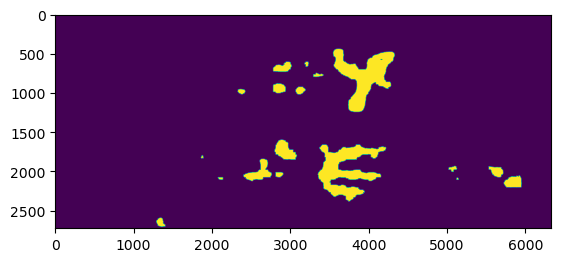

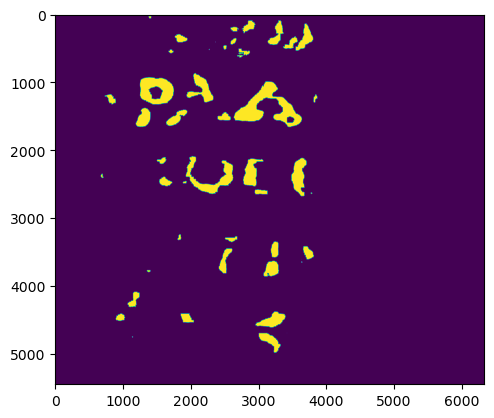

,Id,Predicted
0,a,2807806 15 2814120 41 2820444 54 2826770 59 28...
1,b,203945 33 210275 34 216604 35 222933 37 229263...


In [11]:
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd

submission = defaultdict(list)
# for fragment_id, fragment_name in enumerate(test_fragments):
for fragment_id, pred_image in zip(fragment_ids, preds):
    plt.imshow(pred_image)
    plt.show()
    submission["Id"].append(fragment_id)
    submission["Predicted"].append(fast_rle(pred_image))

pd.DataFrame.from_dict(submission).to_csv("/kaggle/working/submission.csv", index=False)
pd.DataFrame.from_dict(submission)